## Análise de anomalias em criptomoedas

O objetivo deste código é analisar o comportamento de modelos de predição de séries temporais por meio de aprendizado não supervisionado, em um sistema de **AutoEncoder**.

A metodologia do pré-processamento será separar a série temporal dos dados de **fechamento** de cada momento do Bitcoin, com o preço em **dólar**. A partir disso, com o tamanho da janela bem definido, normalizar o conjunto de treinamento e teste e treinar o modelo para predizer a própria entrada. Para familiarização, a imagem abaixo exemplifica bem o que é o sistema de encoder e decoder. No nosso caso, a entrada e saída são iguais, e as features centrais seriam valores numéricos que melhor resume o conjunto temporal.

<img title="a title" style="width: 50%;display: block; margin: 0 auto" alt="Alt text" src="https://www.mdpi.com/IoT/IoT-04-00016/article_deploy/html/images/IoT-04-00016-g001.png">

Será dividido em três modulos aqui, onde cada um terá uma base de dados diferente
1. Histórico do último mês, minuto por minuto
2. Histórico dos últimos 6 anos, dia por dia
3. Histórico de janeiro de 2012 até abril de 2021, minuto por minuto

### Importações

In [1]:
import random
import numpy as np
import pandas as pd
import yfinance as yf
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from datetime import datetime, timedelta


2024-03-06 19:52:09.004004: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-06 19:52:09.050905: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-06 19:52:09.051708: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-06 19:52:10.090115: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Funções auxiliares

In [2]:
def normalize(X_train, X_test, y_train, y_test):
    X_mean = X_train.mean(axis=(0, 1))
    X_std = X_train.std(axis=(0, 1))

    y_mean = y_train.mean(axis=(0, 1))
    y_std = y_train.std(axis=(0, 1))

    X_train = (X_train - X_mean) / X_std
    y_train = (y_train - y_mean) / y_std
    X_test = (X_test - X_mean) / X_std
    y_test = (y_test - y_mean) / y_std

    return X_train, X_test, y_train, y_test, (X_mean, X_std), (y_mean, y_std)

In [3]:
# O modelo será padronizado para todos os testes
def get_autoencoder_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(units=50,input_shape=(X.shape[1], X.shape[2])),
        tf.keras.layers.Dropout(rate=0.2),

        tf.keras.layers.RepeatVector(n=X.shape[1]),
        tf.keras.layers.LSTM(units=50, return_sequences=True),

        tf.keras.layers.Dropout(rate=0.2),
        tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(units=1))
    ])

    model.compile(
        loss="mean_squared_error",
        optimizer="adam"
    )

    return model

In [4]:
def split(X, y, train_size=0.8):
    i = int(X.shape[0] * train_size)
    X_train = X[:i]
    y_train = y[:i]
    X_test = X[i:]
    y_test = y[i:]

    return X_train, X_test, y_train, y_test

In [5]:
def plot_error_graph(X_test, y_test, model, train_size=0.8, threshold=10):
    predicted = model.predict(X_test)

    error = y_test - predicted

    loss = np.mean(np.abs(error), axis=1)

    figure, axis = plt.subplots(1, 2, figsize=(13, 6))

    i = int(X.shape[0] * train_size)

    axis[0].plot(np.arange(i, i+loss.shape[0]), loss, label='Perda')
    axis[0].plot(np.arange(i, i+loss.shape[0]), np.full_like(loss, threshold), label=f'Threshold = {threshold}')

    axis[0].legend()
    axis[0].set_title("Perda na predição da próxima janela temporal de 60 minutos")
    axis[0].set_ylabel("Erro normalizado")
    axis[0].set_xlabel("Minutos")

    axis[1].plot(df["Adj Close"].reset_index(drop=True).loc[i:])
    axis[1].set_title("Desempenho do BTC no mesmo intervalo")
    axis[1].set_xlabel("Minutos")
    axis[1].set_ylabel("Preço Bitcoin")
    plt.show()    

### 1. Histórico do último mês, minuto por minuto

Devido a limitações da biblioteca, é adquirdo os dados por minuto dos últimos 7 dias, gerando por volta de **40.000** resultados

In [6]:
end_date = datetime.now()
start_date = end_date - timedelta(days=7)

df = pd.DataFrame()

for i in range(4):
    btc_data = yf.download('BTC-USD', start=start_date, end=end_date, interval='1m')
    df = pd.concat([df, btc_data.iloc[::-1]])
    end_date = start_date
    start_date = end_date - timedelta(days=7)

df = df.iloc[::-1]

print(df.shape)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

(39034, 6)


#### Pré Processamento

Devido aos valores retornados pelo yfinance de abertura e fechamento serem os mesmos, então é excluído todos, deixando somente uma única coluna, a "*Adj. Close*"

In [7]:
df = df.drop(["Open", "High", "Low", "Close", "Volume"], axis=1)

Criando as janelas de 60 minutos para prever a próxima janela. Poderia também ser a própria janela, serve para a lógica de medição de erros, como será utilizado na última etapa.

In [8]:
WINDOW_SIZE = 60

X = []
y = []

for i in range(0, len(df) - 2*WINDOW_SIZE):
    X.append(df.iloc[i:i+WINDOW_SIZE].values)
    y.append(df.iloc[i+WINDOW_SIZE:i+2*WINDOW_SIZE].values)

X = np.array(X)
y = np.array(y)

In [10]:
X_train, X_test, y_train, y_test = split(X, y)

X_train, X_test, y_train, y_test, scaler_X, scaler_y = normalize(X_train, X_test, y_train, y_test)

model = get_autoencoder_model()

model.fit(X_train, y_train, epochs=5, batch_size=128, validation_split=0.2)

Epoch 1/5
195/195 [==============================] - 23s 99ms/step - loss: 0.0258 - val_loss: 0.6367
Epoch 2/5
195/195 [==============================] - 18s 93ms/step - loss: 0.0069 - val_loss: 0.6113
Epoch 3/5
195/195 [==============================] - 23s 120ms/step - loss: 0.0054 - val_loss: 0.6261
Epoch 4/5
195/195 [==============================] - 21s 110ms/step - loss: 0.0050 - val_loss: 0.6161
Epoch 5/5
195/195 [==============================] - 20s 105ms/step - loss: 0.0048 - val_loss: 0.6653


244/244 [==============================] - 4s 14ms/step


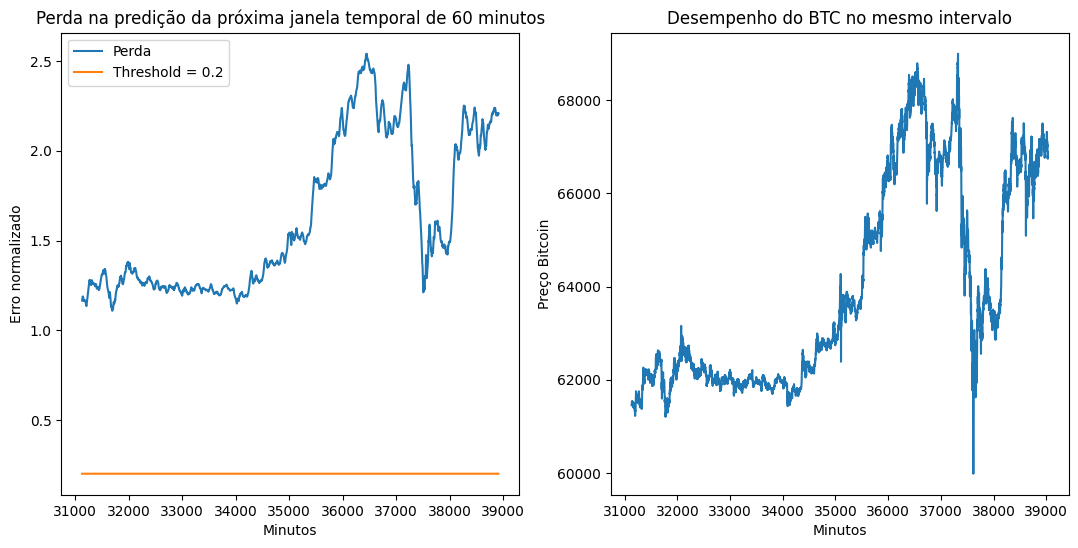

In [11]:
plot_error_graph(X_test, y_test, model, train_size=0.8, threshold=0.2)

In [12]:
X_current = np.concatenate([X_train, X_test])
y_current = np.concatenate([y_train, y_test])

1217/1217 [==============================] - 16s 13ms/step


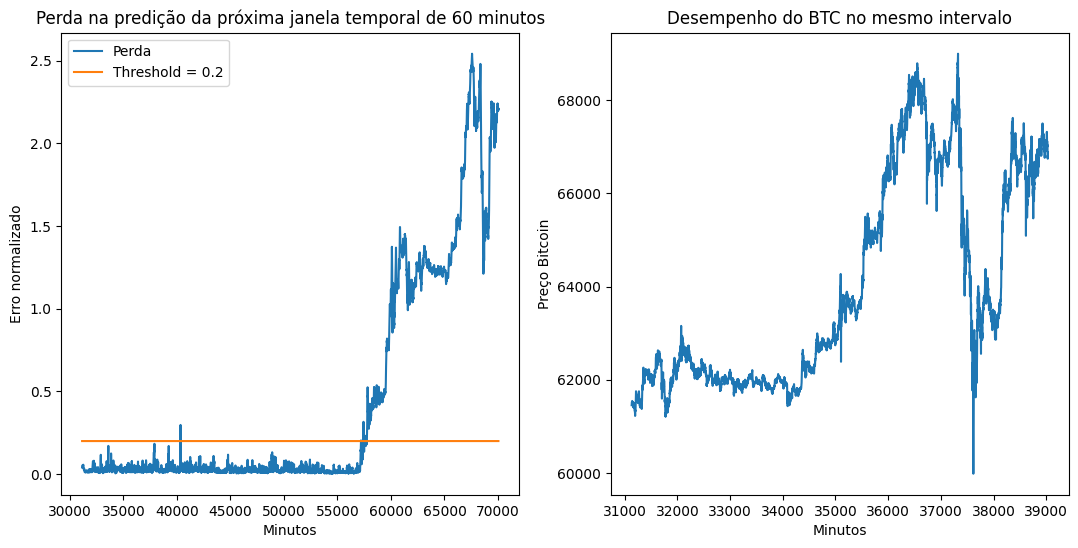

In [13]:
plot_error_graph(X_current, y_current, model, threshold=0.2)

### 2. Histórico dos últimos 6 anos, dia por dia

In [14]:
end_date = datetime.now()
start_date = datetime.now() - timedelta(days=2192)

df = yf.download('BTC-USD', start=start_date, end=end_date, interval='1d')

df = df.drop(["Open", "High", "Low", "Close", "Volume"], axis=1)

WINDOW_SIZE = 60

X = []
y = []

for i in range(0, len(df) - 2*WINDOW_SIZE):
    X.append(df.iloc[i:i+WINDOW_SIZE].values)
    y.append(df.iloc[i+WINDOW_SIZE:i+2*WINDOW_SIZE].values)

X = np.array(X)
y = np.array(y)

X_train, X_test, y_train, y_test = split(X, y, train_size=0.8)

X_train, X_test, y_train, y_test, scaler_X, scaler_y = normalize(X_train, X_test, y_train, y_test)

model = get_autoencoder_model()

[*********************100%%**********************]  1 of 1 completed


In [15]:
model.fit(X_train, y_train, epochs=10, batch_size=128, validation_split=0.1)

Epoch 1/10
12/12 [==============================] - 6s 181ms/step - loss: 0.5414 - val_loss: 0.0640
Epoch 2/10
12/12 [==============================] - 1s 77ms/step - loss: 0.2122 - val_loss: 0.0856
Epoch 3/10
12/12 [==============================] - 1s 97ms/step - loss: 0.1801 - val_loss: 0.1190
Epoch 4/10
12/12 [==============================] - 1s 87ms/step - loss: 0.1673 - val_loss: 0.1431
Epoch 5/10
12/12 [==============================] - 1s 84ms/step - loss: 0.1612 - val_loss: 0.1564
Epoch 6/10
12/12 [==============================] - 1s 82ms/step - loss: 0.1530 - val_loss: 0.1896
Epoch 7/10
12/12 [==============================] - 1s 78ms/step - loss: 0.1437 - val_loss: 0.2306
Epoch 8/10
12/12 [==============================] - 1s 81ms/step - loss: 0.1356 - val_loss: 0.3340
Epoch 9/10
12/12 [==============================] - 1s 80ms/step - loss: 0.1313 - val_loss: 0.3572
Epoch 10/10
12/12 [==============================] - 1s 77ms/step - loss: 0.1260 - val_loss: 0.5248


13/13 [==============================] - 1s 15ms/step


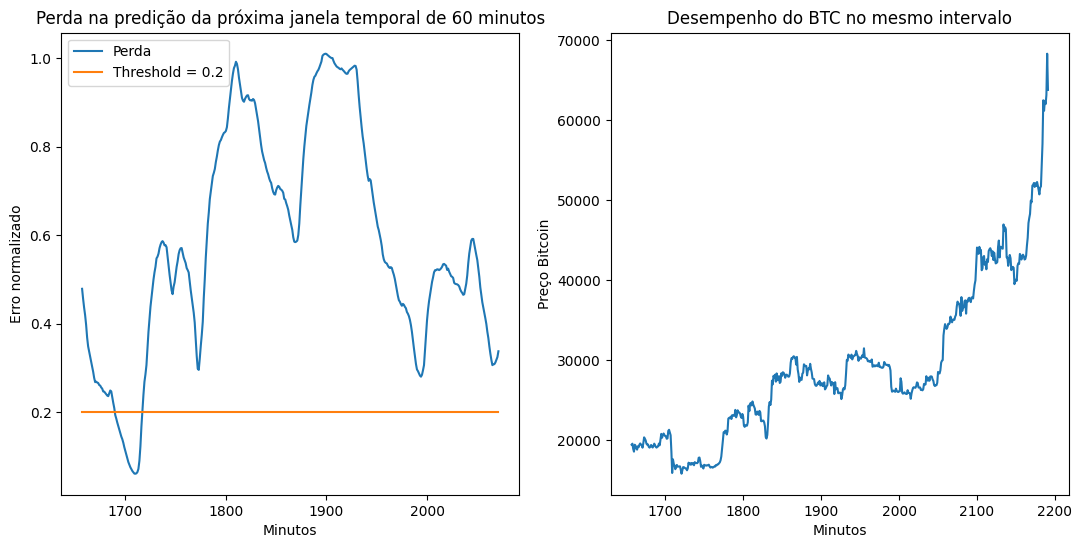

In [16]:
plot_error_graph(X_test, y_test, model, train_size=0.8, threshold=0.2)

65/65 [==============================] - 1s 14ms/step


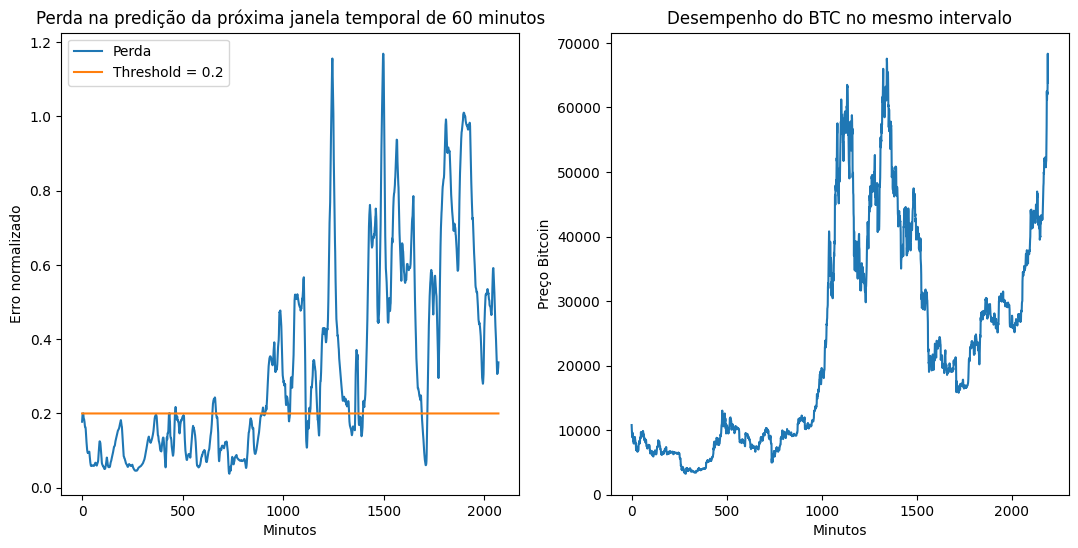

In [17]:
plot_error_graph(np.concatenate([X_train, X_test]), np.concatenate([y_train, y_test]), model, train_size=0.0, threshold=0.2)

### 3. Histórico de janeiro de 2012 até abril de 2021, minuto por minuto

In [18]:
# CSV by kaggle
historical = pd.read_csv("bitcoin-historical-data.csv").dropna().drop(["Timestamp", "Open", "High", "Low", "Weighted_Price", "Volume_(BTC)", "Volume_(Currency)"], axis=1)

In [19]:
# Atualizando o df novamente, para a outra função
end_date = datetime.now()
start_date = end_date - timedelta(days=7)

df = pd.DataFrame()

for i in range(4):
    btc_data = yf.download('BTC-USD', start=start_date, end=end_date, interval='1m')
    df = pd.concat([df, btc_data.iloc[::-1]])
    end_date = start_date
    start_date = end_date - timedelta(days=7)

df = df.iloc[::-1]

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Por motivos de incomputabilidade da minha máquina, limitei a 10.000 janelas temporais o treinamento, sendo selecionadas de forma aleatória, com o custo de não conseguir ter um intervalo temporal de teste ideial.

In [20]:
WINDOW_SIZE = 60

X = []
y = []

indexs = np.array(random.sample(range(0, historical.shape[0] - WINDOW_SIZE), 10000))

for i in indexs:
    X.append(historical.iloc[i:i+WINDOW_SIZE].values)
    y.append(historical.iloc[i:i+WINDOW_SIZE].values)

X = np.array(X)
y = np.array(y)

X_train, _, y_train, _ = split(X, y, train_size=1.0)

X_train, _, y_train, _, scaler_X, scaler_y = normalize(X_train, _, y_train, _)

model = get_autoencoder_model()

In [21]:
model.fit(X_train, y_train, epochs=10, batch_size=128, validation_split=0.1)

Epoch 1/10
71/71 [==============================] - 10s 91ms/step - loss: 0.1726 - val_loss: 0.0229
Epoch 2/10
71/71 [==============================] - 5s 75ms/step - loss: 0.0297 - val_loss: 0.0132
Epoch 3/10
71/71 [==============================] - 6s 83ms/step - loss: 0.0235 - val_loss: 0.0096
Epoch 4/10
71/71 [==============================] - 7s 98ms/step - loss: 0.0194 - val_loss: 0.0073
Epoch 5/10
71/71 [==============================] - 7s 99ms/step - loss: 0.0176 - val_loss: 0.0107
Epoch 6/10
71/71 [==============================] - 6s 86ms/step - loss: 0.0157 - val_loss: 0.0044
Epoch 7/10
71/71 [==============================] - 6s 91ms/step - loss: 0.0144 - val_loss: 0.0053
Epoch 8/10
71/71 [==============================] - 6s 83ms/step - loss: 0.0135 - val_loss: 0.0030
Epoch 9/10
71/71 [==============================] - 6s 86ms/step - loss: 0.0120 - val_loss: 0.0024
Epoch 10/10
71/71 [==============================] - 6s 90ms/step - loss: 0.0121 - val_loss: 0.0031


Mesmo com os dados sendo até 2021, podemos utilizar como teste os dados do último mês do Bitcoin.

1217/1217 [==============================] - 16s 13ms/step


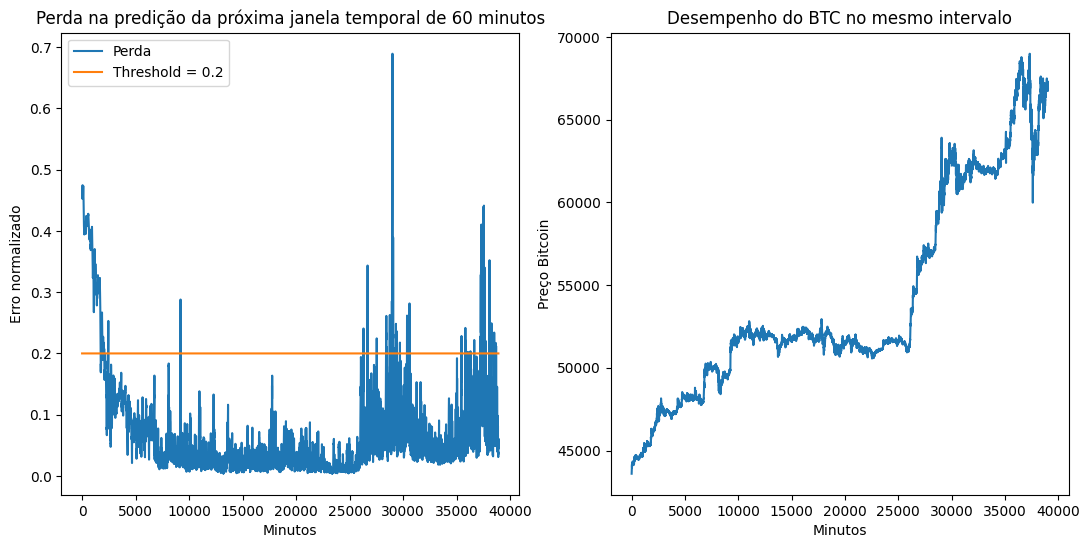

In [22]:
plot_error_graph(X_current, y_current, model, train_size=0.0, threshold=0.2)

Nota-se que os momentos em que passa pelo limiar, são onde anomalias ocorrem no preço do Bitcoin (subidas e descidas disruptivas). Mesmo sem dados recentes o modelo foi capaz de detectar isso.